# Relevant functions

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In [2]:
Xop=sp.sparse.csr_array([[0.,1.],[1.,0.]]) # Pauli X
Yop=sp.sparse.csr_array([[0,-1j],[1j,0.]])
Zop=sp.sparse.csr_array([[1.,0.],[0.,-1]])

In [3]:
def operator(op,idx,N):
  """
  Produce an operator that has single-qubit operator op acting
  on qubit with index idx, and the rest is identity. N is the total number of qubits.
  idx count starts at 0 and runs up to N-1.

  Example: Z_3
  >> operator(Zop,3,10)

  Example: X_0 X_2
  >>  operator(Xop,0,10) @ operator(Xop,2,10)
  """
  return sp.sparse.kron( sp.sparse.identity(2**idx), sp.sparse.kron(op, sp.sparse.identity(2**(N-idx-1))) )

def expectation(psi,op):
  """
  Calculate the expectation value of observable operator op with respect to state psi.
  This takes the real part automatically, assuming op is Hermitean !
  """

  return np.real( np.sum( np.conj(psi) * (op @ psi) ) )

def empty_matrix(n_dim):
  """
  Return the empty sparse matrix for a system of Hilbert space dimension n_dim.
  """
  return sp.sparse.csr_matrix((n_dim, n_dim), dtype='complex')

def produce_XYZ(N):
  """
  Return X,Y,Z = a list of all Pauli X operators, all Pauli Y, all Pauli Z,
  for given qubit number N
  """
  return ( [operator(Xop,idx,N) for idx in range(N)] ,
            [operator(Yop,idx,N) for idx in range(N)] ,
            [operator(Zop,idx,N) for idx in range(N)] )

def ground_state(H):
  """
  Return ground state of H, using sparse Lanczos.
  Returns eigenvalue, eigenvector
  """
  evals,evecs=sp.sparse.linalg.eigsh(H, k=1, which='SA')
  return evals[0], evecs[:,0]

def index_2d(jx,jy,Nx):
  return jx + jy * Nx


# Kitaev model with twisted boundary conditions (general)

In [4]:
twist = 0

In [5]:
# generate all the single-qubit operators:
# Nx, Ny both have to be even (otherwise PBC does not work)
Nx = 8
Ny = 2
N = Nx * Ny # qubit number
X,Y,Z = produce_XYZ(N)

In [6]:
H_theta_term_x = 0 * X[0]
H_theta_term_y = 0 * X[0]
H_theta_term_z = 0 * X[0]
H_theta_term_magnetic = 0 * X[0]

magn_field = 0.00
theta_z = 1

for jx in range(0,Nx):
  for jy in range(0,Ny):
    if ((jx+jy) % 2) == 0:
        H_theta_term_x += X[index_2d(jx,jy,Nx)] @ X[index_2d((jx+1)%Nx,jy,Nx)]
        H_theta_term_z += Z[index_2d(jx,jy,Nx)] @ Z[index_2d((jx+twist)%Nx,(jy-1)%Ny,Nx)]
    else:
       H_theta_term_y += Y[index_2d(jx,jy,Nx)] @ Y[index_2d((jx+1)%Nx,jy,Nx)]
    ## magnetic field in [1,1,1] direction
    H_theta_term_magnetic += X[index_2d(jx,jy,Nx)] + Y[index_2d(jx,jy,Nx)] + Z[index_2d(jx,jy,Nx)]

H_theta_terms = [H_theta_term_x, H_theta_term_y]
H_const = theta_z * H_theta_term_z + magn_field * H_theta_term_magnetic

In [7]:
H_out = [X[index_2d(1,0,Nx)] @ Y[index_2d(1,1,Nx)] @ Z[index_2d(2,1,Nx)] @ X[index_2d(3,1,Nx)] @ Y[index_2d(3,0,Nx)] @ Z[index_2d(2,0,Nx)]]

In [8]:
def KitaevHamiltonianMagneticField(magn_field):
  """
  Construct a QEP Hamiltonian from the given components.

  H0 - untrainable terms in Hamiltonian

  H0_terms - terms for the untrainable part of the Hamiltonian
  theta_0 - parameters that define the phase diagram, untrainable

  theta - a vector (list or array) of trainable parameters
  H_theta_terms - a list of corresponding terms in the Hamiltonian

  Returns the Hamiltonian H as a sum of all these terms.
  """

  H = H_theta_term_x + H_theta_term_y + H_theta_term_z + magn_field * H_theta_term_magnetic

  return H

In [9]:
def HamiltonianPhase(theta, H_theta_terms, H_out, out_coupl):
  """
  Construct a QEP Hamiltonian from the given components.

  H0 - untrainable terms in Hamiltonian

  H0_terms - terms for the untrainable part of the Hamiltonian
  theta_0 - parameters that define the phase diagram, untrainable

  theta - a vector (list or array) of trainable parameters
  H_theta_terms - a list of corresponding terms in the Hamiltonian

  Returns the Hamiltonian H as a sum of all these terms.
  """

  H = sp.sparse.csr_matrix((2**N, 2**N))

  ## trained part of Hamiltonian
  for jj in range(0,len(theta)):
    H += theta[jj] * H_theta_terms[jj]
  
  ## output part of Hamiltonian
  for jj in range(0,len(out_coupl)):
    H += out_coupl[jj] * H_out[jj]
  
  ## fixed constant term
  H += H_const

  return H

# Warm up: getting familiar with the Kitaev honeycomb model

In [10]:
#theta_start = np.array([.1, .4, .5])

theta_start = np.array([1.,1])

#theta_start = np.array([1,1,-1])

In [16]:
H_test = HamiltonianPhase(theta_start, H_theta_terms, H_out, [0.0])

In [12]:
gr_state_test = ground_state(H_test)

In [18]:
%timeit gr_state_test = ground_state(H_test)

427 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Expectation value of the flux operator should be quantised to 1

In [13]:
expectation(gr_state_test[1], H_out[0])

0.9999999999999981

In [15]:
eigs, eigv = sp.sparse.linalg.eigsh(H_test, k=5, which='SA')

In [16]:
eigs

array([-13.44113247, -13.40033919, -12.79293178, -12.79293178,
       -12.79293178])

Sweep of the expectation value of the flux operator for non-zero magnetic field (breaking integrability)

In [17]:
flux_list = np.array([])
for magn_field in np.arange(0,1,.05):
    psi = ground_state(KitaevHamiltonianMagneticField(magn_field))
    flux_list = np.append(flux_list, expectation(psi[1], H_out[0]))

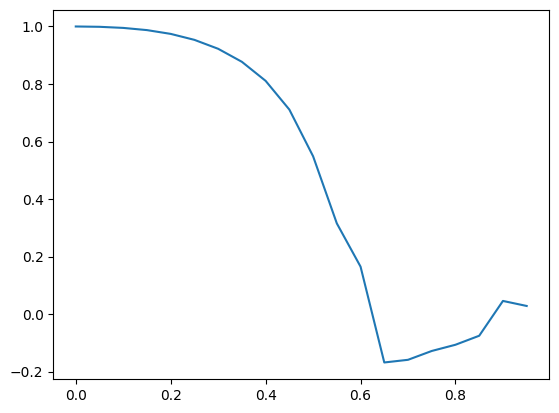

In [18]:
plt.plot(np.arange(0,1,.05), flux_list)

# Training: exploring the phase diagram of the Kitaev honeycomb model with magnetic field in [1,1,1] direction

goal: find the value when the expectation value of the flux operator is maximal

In [ ]:
## twisted boundary conditions, i.e. off-set when connecting the last to the first unit cell along a certain direction
twist = 0

In [12]:
# generate all the single-qubit operators:
# Nx, Ny both have to be even (otherwise PBC does not work)
Nx = 8
Ny = 2
N = Nx * Ny # qubit number
X,Y,Z = produce_XYZ(N)

In [13]:
H_theta_term_x = 0 * X[0]
H_theta_term_y = 0 * X[0]
H_theta_term_z = 0 * X[0]
H_theta_term_magnetic = 0 * X[0]

magn_field = 0.1

for jx in range(0,Nx):
  for jy in range(0,Ny):
    if ((jx+jy) % 2) == 0:
        H_theta_term_x += X[index_2d(jx,jy,Nx)] @ X[index_2d((jx+1)%Nx,jy,Nx)]
        H_theta_term_z += Z[index_2d(jx,jy,Nx)] @ Z[index_2d((jx+twist)%Nx,(jy-1)%Ny,Nx)]
    else:
       H_theta_term_y += Y[index_2d(jx,jy,Nx)] @ Y[index_2d((jx+1)%Nx,jy,Nx)]
    ## magnetic field in [1,1,1] direction
    H_theta_term_magnetic += X[index_2d(jx,jy,Nx)] + Y[index_2d(jx,jy,Nx)] + Z[index_2d(jx,jy,Nx)]

H_theta_terms = [H_theta_term_x, H_theta_term_y]
H_z = H_theta_term_z
H_const = magn_field * H_theta_term_magnetic

In [ ]:
## output operator is the flux operator
H_out = [X[index_2d(1,0,Nx)] @ Y[index_2d(1,1,Nx)] @ Z[index_2d(2,1,Nx)] @ X[index_2d(3,1,Nx)] @ Y[index_2d(3,0,Nx)] @ Z[index_2d(2,0,Nx)]]

In [15]:
def HamiltonianPhase(theta, H_theta_terms, theta_z, H_z, H_out, out_coupl):
  """
  Construct a QEP Hamiltonian from the given components.

  H0 - untrainable terms in Hamiltonian

  H0_terms - terms for the untrainable part of the Hamiltonian
  theta_0 - parameters that define the phase diagram, untrainable

  theta - a vector (list or array) of trainable parameters
  H_theta_terms - a list of corresponding terms in the Hamiltonian

  Returns the Hamiltonian H as a sum of all these terms.
  """

  H = sp.sparse.csr_matrix((2**N, 2**N))

  ## trained part of Hamiltonian
  for jj in range(0,len(theta)):
    H += theta[jj] * H_theta_terms[jj]
  
  H += theta_z * H_z
  
  ## output part of Hamiltonian
  for jj in range(0,len(out_coupl)):
    H += out_coupl[jj] * H_out[jj]
  
  ## fixed constant term
  H += H_const

  return H

system setup and functions for training

In [17]:
## initialise
theta = theta_start

## learning rate
learning_rate = 1e-2

## number of total runs
number_epochs = 40

## iterations
number_iterations = number_epochs #int(number_epochs * len(x_train) / batch_size)

## coupling to output operator (when not in nudge phase)
out_coupl = [0.0]

## nudge parameter scaling eta (uses eta * error_signal)
#nudge = 3*1e-1
nudge = 1e-2

In [18]:
H_theta_term_x = 0 * X[0]
H_theta_term_y = 0 * X[0]
H_theta_term_z = 0 * X[0]
H_theta_term_magnetic = 0 * X[0]

magn_field = 0.1

for jx in range(0,Nx):
  for jy in range(0,Ny):
    if ((jx+jy) % 2) == 0:
        H_theta_term_x += X[index_2d(jx,jy,Nx)] @ X[index_2d((jx+1)%Nx,jy,Nx)]
        H_theta_term_z += Z[index_2d(jx,jy,Nx)] @ Z[index_2d((jx+twist)%Nx,(jy-1)%Ny,Nx)]
    else:
       H_theta_term_y += Y[index_2d(jx,jy,Nx)] @ Y[index_2d((jx+1)%Nx,jy,Nx)]
    ## magnetic field in [1,1,1] direction
    H_theta_term_magnetic += X[index_2d(jx,jy,Nx)] + Y[index_2d(jx,jy,Nx)] + Z[index_2d(jx,jy,Nx)]

In [19]:
H_z = H_theta_term_z
H_theta_terms_constrained = [H_theta_term_x - H_z, H_theta_term_y - H_z]
H_const = magn_field * H_theta_term_magnetic + H_z

In [20]:
def HamiltonianPhase_optimization(theta, H_theta_terms_constrained, H_out, out_coupl):
  """
  Construct a QEP Hamiltonian from the given components.

  H0 - untrainable terms in Hamiltonian

  H0_terms - terms for the untrainable part of the Hamiltonian
  theta_0 - parameters that define the phase diagram, untrainable

  theta - a vector (list or array) of trainable parameters
  H_theta_terms - a list of corresponding terms in the Hamiltonian

  Returns the Hamiltonian H as a sum of all these terms.
  """

  H = sp.sparse.csr_matrix((2**N, 2**N))

  ## trained part of Hamiltonian
  for jj in range(0,len(theta)):
    H += theta[jj] * H_theta_terms_constrained[jj]
  
  ## output part of Hamiltonian
  for jj in range(0,len(out_coupl)):
    H += out_coupl[jj] * H_out[jj]
  
  ## fixed constant term
  H += H_const

  return H

In [21]:
## maximizes expectation value
def cost_func(theta, H_theta_terms_constrained, H_out, out_coupl):
    _, eigVect_1 = ground_state(HamiltonianPhase_optimization(theta, H_theta_terms_constrained, H_out, out_coupl))
    return - np.abs(sum(expectation(eigVect_1, H_out[jj]) for jj in range(0,len(out_coupl))))

In [ ]:
## extract gradients with QEP for training
def get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge):

    _, eigVect = ground_state(HamiltonianPhase_optimization(theta, H_theta_terms_constrained, H_out, out_coupl))

    expect_sign = np.array([np.sign(expectation(eigVect, H_out[jj])) for jj in range(0,len(H_out))])
    
    _, eigVect_nudge = ground_state(HamiltonianPhase_optimization(theta, H_theta_terms_constrained, H_out, out_coupl + np.array([nudge])))

    diff_theta = np.array([[expect_sign[0] * (expectation(eigVect_nudge, H_theta_terms_constrained[jj]) - expectation(eigVect, H_theta_terms_constrained[jj]))/nudge] for jj in range(0,len(H_theta_terms_constrained))])

    gradient_norm = np.linalg.norm(diff_theta)

    return - diff_theta / gradient_norm

starting points in the phase diagram

In [ ]:
## returns Jx, Jy, Jz from the given x and y points in triangular slice of phase diagram
def Jxyz_map(x_val, y_val):
    Jz = 2/np.sqrt(3) * y_val
    Jy = x_val - Jz / 2
    Jx = 1 - Jz - Jy
    return [Jx,Jy,Jz]

In [ ]:
## example use: give x and y points in triangular slice of phase diagram and get values of Jx, Jy, Jz
Jxyz_map(.75, .4)

[0.01905989232414962, 0.5190598923241496, 0.4618802153517007]

In [168]:
## more interesting starting points

test_list = np.array([## middle
                      #[.375,.375,.25],
                      #[.25,.375,.375],
                      #[.375,.25,.375],
                      ## top
                      [1/6,1/6,2/3],
                      ## left
                      [2/3,1/6,1/6],
                      ## right
                      [1-.3-.55,.3,.55],
                      ## bottom
                      [1-2/np.sqrt(3)*0.18-(.6-2/np.sqrt(3)*0.18),.6-2/np.sqrt(3)*0.18,2/np.sqrt(3)*0.18],
                      [1-2/np.sqrt(3)*0.18-(.7-2/np.sqrt(3)*0.18),.7-2/np.sqrt(3)*0.18,2/np.sqrt(3)*0.18],
                      Jxyz_map(.75, .4),
                      Jxyz_map(.35, .55),
                      Jxyz_map(.65, .4),
                      Jxyz_map(.35, .45)
                      ])

theta_start_list = test_list[:,0:2]

training runs

In [23]:
cost_func_list = np.zeros((len(theta_start_list),number_iterations+1))
theta_list = np.zeros((len(theta_start_list),number_iterations+1,2))

for ll in range(len(theta_start_list)):
    theta = theta_start_list[ll]

    learning_rate_decay = 0.0
    epoch = 0

    learning_rate_t = learning_rate

    for jj in range(0,number_iterations):
        tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
        tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

        ## learning rate decay
        #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
        #epoch += 1

        theta_list[ll,jj] = theta
        cost_func_list[ll,jj] = tmp_cost_func

        theta -= learning_rate_t * tmp_grad.flatten()

    theta_list[ll,number_iterations] = theta
    cost_func_list[ll,number_iterations] = tmp_cost_func

In [216]:
cost_func_list = np.array([])
theta_list = np.array([])

number_iterations = 40

for ll in range(len(theta_start_list)):
    theta = theta_start_list[ll]

    learning_rate_decay = 0.0
    epoch = 0

    learning_rate_t = learning_rate

    for jj in range(0,number_iterations):
        tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
        tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

        ## learning rate decay
        #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
        #epoch += 1

        theta_list = np.append(theta_list, theta)
        cost_func_list = np.append(cost_func_list, tmp_cost_func)

        theta -= learning_rate_t * tmp_grad.flatten()

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [162]:
theta_list = theta_list.flatten()

In [53]:
## add another trajectory
 
theta = theta_start_list[3]

learning_rate_decay = 0.0
epoch = 0

learning_rate_t = learning_rate

for jj in range(0,number_iterations):
    tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
    tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

    ## learning rate decay
    #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
    #epoch += 1

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

    theta -= learning_rate_t * tmp_grad.flatten()

theta_list = np.append(theta_list, theta)
cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [77]:
## add another trajectory
 
theta = theta_start_list[4]

learning_rate_decay = 0.0
epoch = 0

learning_rate_t = learning_rate

for jj in range(0,number_iterations):
    tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
    tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

    ## learning rate decay
    #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
    #epoch += 1

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

    theta -= learning_rate_t * tmp_grad.flatten()

theta_list = np.append(theta_list, theta)
cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [163]:
## add another trajectory
 
theta = theta_start_list[5]

learning_rate_decay = 0.0
epoch = 0

learning_rate_t = learning_rate

for jj in range(0,number_iterations):
    tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
    tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

    ## learning rate decay
    #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
    #epoch += 1

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

    theta -= learning_rate_t * tmp_grad.flatten()

theta_list = np.append(theta_list, theta)
cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [164]:
## add another trajectory
 
theta = theta_start_list[6]

learning_rate_decay = 0.0
epoch = 0

learning_rate_t = learning_rate

for jj in range(0,number_iterations):
    tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
    tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

    ## learning rate decay
    #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
    #epoch += 1

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

    theta -= learning_rate_t * tmp_grad.flatten()

theta_list = np.append(theta_list, theta)
cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [169]:
theta_list = theta_list.reshape(len(theta_start_list),number_iterations+1,2)
cost_func_list = cost_func_list.reshape(len(theta_start_list),number_iterations+1)

save results

In [170]:
theta_list_tmp = theta_list

In [59]:
import os
cwd = os.getcwd()

In [ ]:
import os
cwd = os.getcwd()
os.chdir("/.") # <-- replace with relevant file directory

In [185]:
np.savez("theta_trajectories_nudge0p01.nz",theta_list)
np.savez("cost_functions_nudge0p01.nz",cost_func)

In [216]:
np.savez("theta_trajectories_asymmetric_2_nudge0p01.nz",theta_list)
np.savez("cost_functions_asymmetric_2_nudge0p01.nz",cost_func)

cost functions for the different starting points

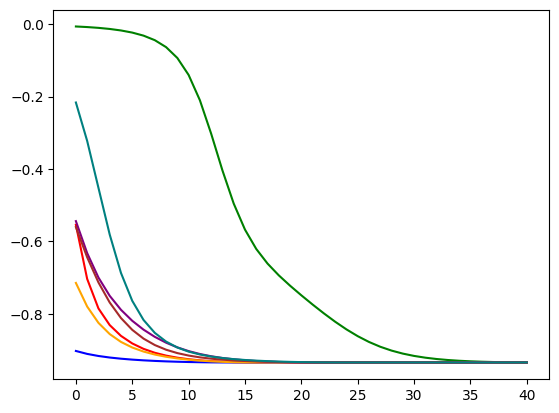

In [186]:
plt.plot(cost_func_list[0],c='red')
plt.plot(cost_func_list[1],c='green')
plt.plot(cost_func_list[2],c='blue')
plt.plot(cost_func_list[3],c='orange')
plt.plot(cost_func_list[4],c='purple')
#plt.plot(cost_func_list[5],c='brown')
#plt.plot(cost_func_list[6],c='yellow')
plt.plot(cost_func_list[7],c='brown')
plt.plot(cost_func_list[8],c=[0,.5,.5,1])

plt.savefig('loss_function_h=0p05_asymmetric.pdf')

# Plot of phase diagram and trajectories

Phase diagram sweep: plot expectation value of flux operator in phase diagram

In [43]:
def phase_diagram_2D_sweep(op, sweep1, sweep2, theta, out_coupl, resolution):
    ## h_min, h_max: min and max of parameter sweep (the same for both parameters that are swept)
    ## sweep1, sweep2: indices of the two parameters that are swept
    ## out_coupl: coupling strength to output operator
    ## resolution: step
    tmp = np.array([])
    theta_sweep = theta
    for Jx in np.arange(0,1+resolution,resolution):
        for Jy in np.arange(0,1-Jx+resolution,resolution):
            Jz = 1 - Jx - Jy
            theta_sweep = np.array([Jx,Jy])
            _, eigVect = ground_state(HamiltonianPhase_optimization(theta_sweep,H_theta_terms_constrained, H_out, out_coupl))
            tmp = np.append(tmp, [Jx, Jy, Jz, expectation(eigVect,op)])
    return tmp

In [44]:
## sweep parameters of X[j] term and Z[j] @ Z[j+1] terms
phase_diag_slice = phase_diagram_2D_sweep(H_out[0], 0, 1, np.array([0.0, 0.0]), [0.0], .05)

In [96]:
## sweep parameters of X[j] term and Z[j] @ Z[j+1] terms
phase_diag_slice_test = phase_diagram_2D_sweep(H_out[0], 0, 1, np.array([0.0, 0.0]), [0.0], .2)

In [45]:
list_len = int(len(phase_diag_slice)/4)

In [46]:
phase_diag_slice = np.reshape(phase_diag_slice,(list_len,4))

In [195]:
np.savez("phase_diagram_flux_expectation.nz",phase_diag_slice)

In [36]:
def diag_map(Jx,Jy,Jz):
    return [Jy+Jz/2, Jz/2 * np.sqrt(3)]

In [47]:
phase_diag_slice_remap = np.array([])
for jj in range(0,len(phase_diag_slice)):
    tmp = diag_map(phase_diag_slice[jj,0],phase_diag_slice[jj,1],phase_diag_slice[jj,2])
    phase_diag_slice_remap = np.append(phase_diag_slice_remap, [tmp[0],tmp[1],phase_diag_slice[jj,3]])
phase_diag_slice_remap = np.reshape(phase_diag_slice_remap, (list_len,3))

In [197]:
np.savetxt("phase_diagram_magnetic_field_0p1.csv", phase_diag_slice, delimiter=",") # evaluate the command according to the run that is executed (for run2, see below)

In [231]:
np.savez("phase_diagram_magnetic_field_0p1.nz",phase_diag_slice)

(-0.02, 0.89)

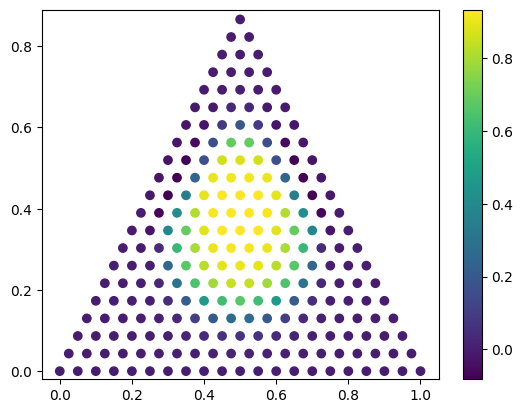

In [48]:
plt.scatter(phase_diag_slice_remap[:,0],phase_diag_slice_remap[:,1],c=phase_diag_slice_remap[:,2])
plt.colorbar()
plt.ylim([-.02,.89])

Plot trajectories

In [175]:
theta_list_0 = theta_list[0].reshape((number_epochs+1,2))
theta_list_1 = theta_list[1].reshape((number_epochs+1,2))
theta_list_2 = theta_list[2].reshape((number_epochs+1,2))
theta_list_3 = theta_list[3].reshape((number_epochs+1,2))
theta_list_4 = theta_list[4].reshape((number_epochs+1,2))
theta_list_5 = theta_list[5].reshape((number_epochs+1,2))
theta_list_6 = theta_list[6].reshape((number_epochs+1,2))
theta_list_7 = theta_list[7].reshape((number_epochs+1,2))
theta_list_8 = theta_list[8].reshape((number_epochs+1,2))

In [176]:
theta_list_0_diag = np.zeros((len(theta_list_0),2))
for jj in range (0,len(theta_list_0)):
    theta_list_0_diag[jj] = diag_map(theta_list_0[jj,0],theta_list_0[jj,1], 1 - theta_list_0[jj,0] - theta_list_0[jj,1])

theta_list_1_diag = np.zeros((len(theta_list_1),2))
for jj in range (0,len(theta_list_1)):
    theta_list_1_diag[jj] = diag_map(theta_list_1[jj,0],theta_list_1[jj,1], 1 - theta_list_1[jj,0] - theta_list_1[jj,1])

theta_list_2_diag = np.zeros((len(theta_list_2),2))
for jj in range (0,len(theta_list_2)):
    theta_list_2_diag[jj] = diag_map(theta_list_2[jj,0],theta_list_2[jj,1], 1 - theta_list_2[jj,0] - theta_list_2[jj,1])

theta_list_3_diag = np.zeros((len(theta_list_3),2))
for jj in range (0,len(theta_list_3)):
    theta_list_3_diag[jj] = diag_map(theta_list_3[jj,0],theta_list_3[jj,1], 1 - theta_list_3[jj,0] - theta_list_3[jj,1])

theta_list_4_diag = np.zeros((len(theta_list_4),2))
for jj in range (0,len(theta_list_4)):
    theta_list_4_diag[jj] = diag_map(theta_list_4[jj,0],theta_list_4[jj,1], 1 - theta_list_4[jj,0] - theta_list_4[jj,1])

theta_list_5_diag = np.zeros((len(theta_list_5),2))
for jj in range (0,len(theta_list_4)):
    theta_list_5_diag[jj] = diag_map(theta_list_5[jj,0],theta_list_5[jj,1], 1 - theta_list_5[jj,0] - theta_list_5[jj,1])

theta_list_6_diag = np.zeros((len(theta_list_6),2))
for jj in range (0,len(theta_list_6)):
    theta_list_6_diag[jj] = diag_map(theta_list_6[jj,0],theta_list_6[jj,1], 1 - theta_list_6[jj,0] - theta_list_6[jj,1])

theta_list_7_diag = np.zeros((len(theta_list_7),2))
for jj in range (0,len(theta_list_6)):
    theta_list_7_diag[jj] = diag_map(theta_list_7[jj,0],theta_list_7[jj,1], 1 - theta_list_7[jj,0] - theta_list_7[jj,1])

theta_list_8_diag = np.zeros((len(theta_list_8),2))
for jj in range (0,len(theta_list_6)):
    theta_list_8_diag[jj] = diag_map(theta_list_8[jj,0],theta_list_8[jj,1], 1 - theta_list_8[jj,0] - theta_list_8[jj,1])

In [177]:
theta_start_list_remap = np.array([])
for jj in range(0,len(theta_start_list)):
    tmp = diag_map(theta_start_list[jj,0],theta_start_list[jj,1],1-theta_start_list[jj,0]-theta_start_list[jj,1])
    theta_start_list_remap = np.append(theta_start_list_remap, tmp)
theta_start_list_remap = np.reshape(theta_start_list_remap, (len(theta_start_list),2))

In [206]:
red_color_list = [[np.sqrt(x), 0, 0, 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
blue_color_list = [[.3*x, 0.3*x, np.sqrt(x), 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
green_color_list = [[0, .8*np.sqrt(x), 0, 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
orange_color_list = [[1.0*np.sqrt(np.sqrt(x)), .5*np.sqrt(np.sqrt(x)), 0, 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
purple_color_list = [[.7*np.sqrt(x), 0, np.sqrt(x), 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
brown_color_list = [[.6*np.sqrt(x), .3*np.sqrt(x), 0, 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
teal_color_list = [[0, .4*np.sqrt(x), .7*np.sqrt(x), 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]

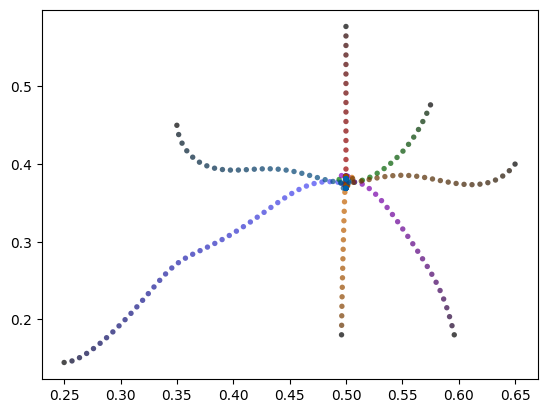

In [207]:
alpha_val = 0.7
marker_size = 15

plt.scatter(theta_list_0_diag[:,0], theta_list_0_diag[:,1], edgecolors='none', facecolors=red_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_1_diag[:,0], theta_list_1_diag[:,1], edgecolors='none', facecolors=blue_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_2_diag[:,0], theta_list_2_diag[:,1], edgecolors='none', facecolors=green_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_3_diag[:,0], theta_list_3_diag[:,1], edgecolors='none', facecolors=orange_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_4_diag[:,0], theta_list_4_diag[:,1], edgecolors='none', facecolors=purple_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')

plt.scatter(theta_list_7_diag[:,0], theta_list_7_diag[:,1], edgecolors='none', facecolors=brown_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_8_diag[:,0], theta_list_8_diag[:,1], edgecolors='none', facecolors=teal_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')

Combined plot

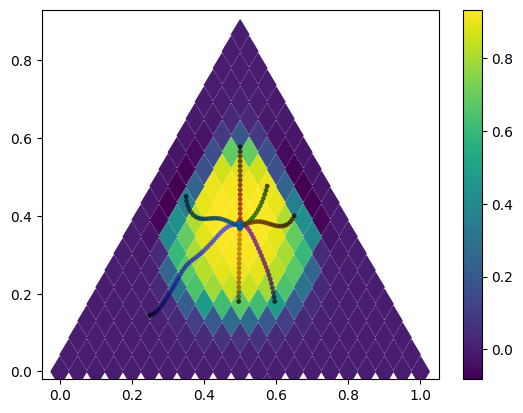

In [213]:
max_iter = 40

alpha_val = 0.7
marker_size = 12
edge_cl = 'none'

plt.scatter(phase_diag_slice_remap[:,0],phase_diag_slice_remap[:,1],c=phase_diag_slice_remap[:,2], s=220, marker='d')
plt.colorbar()
plt.scatter(theta_list_0_diag[:,0], theta_list_0_diag[:,1], edgecolors=edge_cl, facecolors=red_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_1_diag[:,0], theta_list_1_diag[:,1], edgecolors=edge_cl, facecolors=blue_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_2_diag[:,0], theta_list_2_diag[:,1], edgecolors=edge_cl, facecolors=green_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_3_diag[:,0], theta_list_3_diag[:,1], edgecolors=edge_cl, facecolors=orange_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_4_diag[:,0], theta_list_4_diag[:,1], edgecolors=edge_cl, facecolors=purple_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_7_diag[:,0], theta_list_7_diag[:,1], edgecolors=edge_cl, facecolors=brown_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.scatter(theta_list_8_diag[:,0], theta_list_8_diag[:,1], edgecolors=edge_cl, facecolors=teal_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.ylim([-.02,.93])

plt.savefig('phase_diag_trajectories_h=0p1_asymmetric.pdf')

# Different values of nudgings

small nudging means the gradient is computed more accurately, larger nudging can lead to the incorrect calculation of the gradient

nudge = $10^{-2}$

In [292]:
nudge = 1e-2

In [293]:
## more interesting starting points

test_list = np.array([## left
                      [2/3,1/6,1/6]
                      ])

theta_start_list = test_list[:,0:2]

In [294]:
cost_func_list = np.array([])
theta_list = np.array([])

number_iterations = 40

for ll in range(len(theta_start_list)):
    theta = theta_start_list[ll]

    learning_rate_decay = 0.0
    epoch = 0

    learning_rate_t = learning_rate

    for jj in range(0,number_iterations):
        tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
        tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

        ## learning rate decay
        #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
        #epoch += 1

        theta_list = np.append(theta_list, theta)
        cost_func_list = np.append(cost_func_list, tmp_cost_func)

        theta -= learning_rate_t * tmp_grad.flatten()

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [295]:
theta_list = theta_list.reshape(len(theta_start_list),number_iterations+1,2)
cost_func_list = cost_func_list.reshape(len(theta_start_list),number_iterations+1)

In [296]:
theta_list_0 = theta_list[0].reshape((number_epochs+1,2))

In [297]:
theta_list_0_diag = np.zeros((len(theta_list_0),2))
for jj in range (0,len(theta_list_0)):
    theta_list_0_diag[jj] = diag_map(theta_list_0[jj,0],theta_list_0[jj,1], 1 - theta_list_0[jj,0] - theta_list_0[jj,1])

In [298]:
np.savez("trajectory_nudge0p01.nz",theta_list_0_diag)

In [299]:
lightblue_color_list = [[0, 0, np.sqrt(np.sqrt(x)), 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
lightred_color_list = [[np.sqrt(np.sqrt(x)), 0, 0, 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]

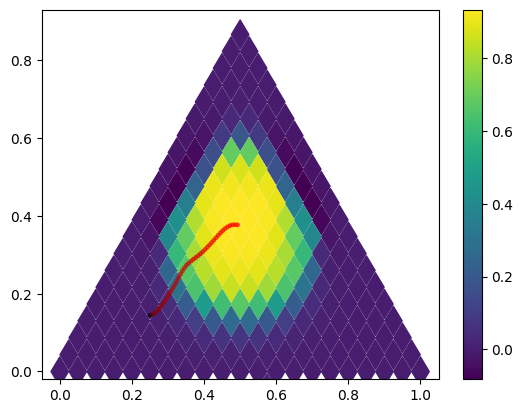

In [300]:
max_iter = 40

alpha_val = 0.7
marker_size = 12
edge_cl = 'none'

plt.scatter(phase_diag_slice_remap[:,0],phase_diag_slice_remap[:,1],c=phase_diag_slice_remap[:,2], s=220, marker='d')
plt.colorbar()
plt.scatter(theta_list_0_diag[:,0], theta_list_0_diag[:,1], edgecolors=edge_cl, facecolors=lightred_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.ylim([-.02,.93])

plt.savefig('phase_diag_trajectories_h=0p1_nudge0p01.pdf')

nudge = $10^{-3}$

In [283]:
nudge = 1e-3

In [284]:
## more interesting starting points

test_list = np.array([## left
                      [2/3,1/6,1/6]
                      ])

theta_start_list = test_list[:,0:2]

In [285]:
cost_func_list = np.array([])
theta_list = np.array([])

number_iterations = 40

for ll in range(len(theta_start_list)):
    theta = theta_start_list[ll]

    learning_rate_decay = 0.0
    epoch = 0

    learning_rate_t = learning_rate

    for jj in range(0,number_iterations):
        tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
        tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

        ## learning rate decay
        #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
        #epoch += 1

        theta_list = np.append(theta_list, theta)
        cost_func_list = np.append(cost_func_list, tmp_cost_func)

        theta -= learning_rate_t * tmp_grad.flatten()

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [286]:
theta_list = theta_list.reshape(len(theta_start_list),number_iterations+1,2)
cost_func_list = cost_func_list.reshape(len(theta_start_list),number_iterations+1)

In [287]:
theta_list_0 = theta_list[0].reshape((number_epochs+1,2))

In [288]:
theta_list_0_diag = np.zeros((len(theta_list_0),2))
for jj in range (0,len(theta_list_0)):
    theta_list_0_diag[jj] = diag_map(theta_list_0[jj,0],theta_list_0[jj,1], 1 - theta_list_0[jj,0] - theta_list_0[jj,1])

In [289]:
np.savez("trajectory_nudge0p001.nz",theta_list_0_diag)

In [290]:
lightblue_color_list = [[0, 0, np.sqrt(np.sqrt(x)), 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
lightred_color_list = [[np.sqrt(np.sqrt(x)), 0, 0, 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]

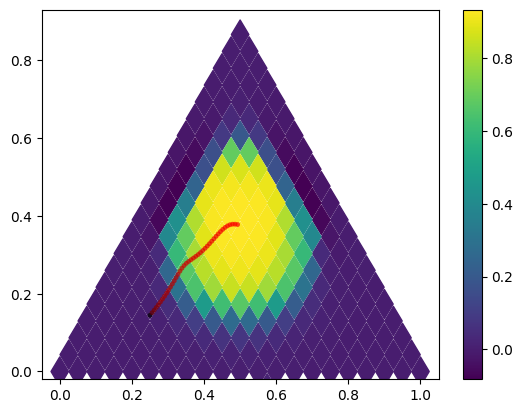

In [291]:
max_iter = 40

alpha_val = 0.7
marker_size = 12
edge_cl = 'none'

plt.scatter(phase_diag_slice_remap[:,0],phase_diag_slice_remap[:,1],c=phase_diag_slice_remap[:,2], s=220, marker='d')
plt.colorbar()
plt.scatter(theta_list_0_diag[:,0], theta_list_0_diag[:,1], edgecolors=edge_cl, facecolors=lightred_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.ylim([-.02,.93])

plt.savefig('phase_diag_trajectories_h=0p1_nudge0p001.pdf')

nudge = $10^{-1}$

In [267]:
nudge = 1e-1

In [268]:
## more interesting starting points

test_list = np.array([## left
                      [2/3,1/6,1/6]
                      ])

theta_start_list = test_list[:,0:2]

In [269]:
cost_func_list = np.array([])
theta_list = np.array([])

number_iterations = 40

for ll in range(len(theta_start_list)):
    theta = theta_start_list[ll]

    learning_rate_decay = 0.0
    epoch = 0

    learning_rate_t = learning_rate

    for jj in range(0,number_iterations):
        tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
        tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

        ## learning rate decay
        #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
        #epoch += 1

        theta_list = np.append(theta_list, theta)
        cost_func_list = np.append(cost_func_list, tmp_cost_func)

        theta -= learning_rate_t * tmp_grad.flatten()

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [270]:
theta_list = theta_list.reshape(len(theta_start_list),number_iterations+1,2)
cost_func_list = cost_func_list.reshape(len(theta_start_list),number_iterations+1)

In [271]:
theta_list_0 = theta_list[0].reshape((number_epochs+1,2))

In [272]:
theta_list_0_diag = np.zeros((len(theta_list_0),2))
for jj in range (0,len(theta_list_0)):
    theta_list_0_diag[jj] = diag_map(theta_list_0[jj,0],theta_list_0[jj,1], 1 - theta_list_0[jj,0] - theta_list_0[jj,1])

In [273]:
np.savez("trajectory_nudge0p1.nz",theta_list_0_diag)

In [280]:
lightblue_color_list = [[0, 0, np.sqrt(np.sqrt(x)), 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]
lightred_color_list = [[np.sqrt(np.sqrt(x)), 0, 0, 1.0] for x in np.arange(0.0,1,1/len(theta_list_0_diag))]

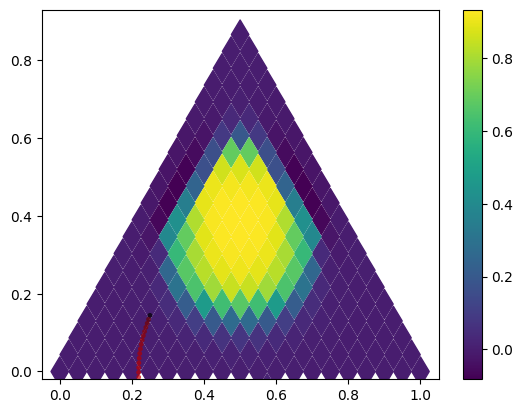

In [282]:
max_iter = 40

alpha_val = 0.7
marker_size = 12
edge_cl = 'none'

plt.scatter(phase_diag_slice_remap[:,0],phase_diag_slice_remap[:,1],c=phase_diag_slice_remap[:,2], s=220, marker='d')
plt.colorbar()
plt.scatter(theta_list_0_diag[:,0], theta_list_0_diag[:,1], edgecolors=edge_cl, facecolors=lightred_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.ylim([-.02,.93])

plt.savefig('phase_diag_trajectories_h=0p1_nudge0p1.pdf')

nudge = $0.5$

In [224]:
nudge = 0.5

In [225]:
## more interesting starting points

test_list = np.array([## left
                      [2/3,1/6,1/6]
                      ])

theta_start_list = test_list[:,0:2]

In [226]:
cost_func_list = np.array([])
theta_list = np.array([])

number_iterations = 40

for ll in range(len(theta_start_list)):
    theta = theta_start_list[ll]

    learning_rate_decay = 0.0
    epoch = 0

    learning_rate_t = learning_rate

    for jj in range(0,number_iterations):
        tmp_grad = get_gradient(theta, H_theta_terms_constrained, H_out, out_coupl, nudge)
        tmp_cost_func = cost_func(theta, H_theta_terms_constrained, H_out, out_coupl)

        ## learning rate decay
        #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
        #epoch += 1

        theta_list = np.append(theta_list, theta)
        cost_func_list = np.append(cost_func_list, tmp_cost_func)

        theta -= learning_rate_t * tmp_grad.flatten()

    theta_list = np.append(theta_list, theta)
    cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [229]:
theta_list = theta_list.reshape(len(theta_start_list),number_iterations+1,2)
cost_func_list = cost_func_list.reshape(len(theta_start_list),number_iterations+1)

In [230]:
theta_list_0 = theta_list[0].reshape((number_epochs+1,2))

In [231]:
theta_list_0_diag = np.zeros((len(theta_list_0),2))
for jj in range (0,len(theta_list_0)):
    theta_list_0_diag[jj] = diag_map(theta_list_0[jj,0],theta_list_0[jj,1], 1 - theta_list_0[jj,0] - theta_list_0[jj,1])

In [241]:
np.savez("trajectory_nudge0p5.nz",theta_list_0_diag)

In [264]:
theta_list_0_diag = np.load('trajectory_nudge0p5.nz.npz')['arr_0']

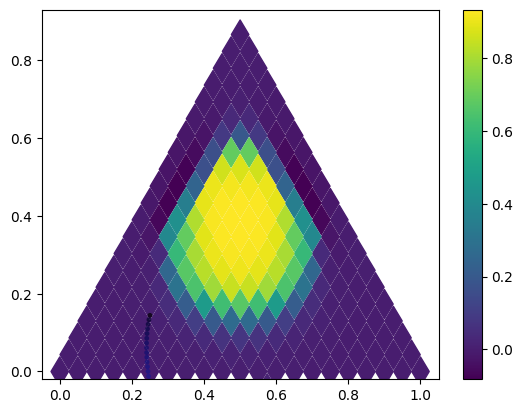

In [266]:
max_iter = 40

alpha_val = 0.7
marker_size = 12
edge_cl = 'none'

plt.scatter(phase_diag_slice_remap[:,0],phase_diag_slice_remap[:,1],c=phase_diag_slice_remap[:,2], s=220, marker='d')
plt.colorbar()
plt.scatter(theta_list_0_diag[:,0], theta_list_0_diag[:,1], edgecolors=edge_cl, facecolors=blue_color_list, s=marker_size, zorder=1, alpha=alpha_val, marker='o')
plt.ylim([-.02,.93])

plt.savefig('phase_diag_trajectories_h=0p1_nudge0p5.pdf')